## This script:
### -Identifies the optimal hyperparameters for an XGBoost model trained on our data
### -Trains this optimized model 
### -Deploys this optimized model 
### -Assesses this model in terms of statistical prowess and operational impact
<br><br>
### Outline of Notebook:

#### 2.1 Establish environment and define variables
#### 2.2 Tune Hyperparameters
#### 2.3 Train Optimized Model
#### 2.4 Deploy Optimized Model
#### 2.5 Make Batch Predictions on Test Data
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>CSV_Reader()</u>
#### 2.6 Identify Optimal Likelihood Cutoff for Predictions
#### 2.7 Evaluate Model<br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Plot_Confusion_Matrix()</u>
#### 2.8 Feature Importance
#### 2.9 Assess Financial/Operational Impact of Model

### 2.1 Establish Environment and Define Variables

In [1]:
#The first step is to import the necessary libraries

#Data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime
#from sklearn.utils import shuffle
from time import gmtime, strftime
%matplotlib inline

#Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#AWS Sagemaker libraries
import sagemaker
import boto3
import io
from io import StringIO
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
import os
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri

#Libraries needed to evaluate/produce machine learning models
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier as rfc

#Defining some global variables for Sagemaker
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


#### As this is a fairly large dataset we will reformat the default display dimensions to reflect this.

In [2]:
#500 rows and columns will be presented
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

#### Defining the names of different directory folders and files to be called upon later in the script.

In [3]:
#Head repository
bucket = 'diabetes-directory'
#Relevant subfolders
processed_data_subfolder = 'processed_data_location'
xgb_subfolder = 'xgb'
hyperparameter_tuning_subfolder = 'tuning'
tuned_model_subfolder = 'optimized_model'
#Input files
train_file = 'train.csv'
validation_file = 'validation.csv'
test_file = 'test.csv'
full_cleaned_dataset = 'aggregate_cleaned_data.csv'

#File paths for model data
s3_train_filepath = 's3://{}/{}/{}'.format(bucket, processed_data_subfolder, train_file)
s3_validation_filepath ='s3://{}/{}/{}'.format(bucket, processed_data_subfolder, validation_file)

#File paths for model output
hyperparameter_tuning_output = "s3://{}/{}/{}/output".format(bucket, xgb_subfolder, hyperparameter_tuning_subfolder)
tuned_model_output = 's3://{}/{}/{}/'.format(bucket, xgb_subfolder, tuned_model_subfolder)

#Tuning and training 
tuning_job_name = 'diabetes-XGB-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
#optimized_job_name = 'diabetes-XGB-job-optimized-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))


### 2.2 Tune Hyperparameters

#### We begin by defining a range of hyperparameters for our XGB model to cycle through.
We are initiating 50 individual jobs to see which produces the highes AUC value.

In [4]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 50,
      "MaxParallelTrainingJobs": 5
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    },
    "RandomSeed" : 123
  }

#### Now we set up the resources for our XGB model, feed in the input/output locations as well as our defined hyperparameter ranges, and initiate the session.

The hyperparameter-tuning-job can be monitored, and even set up/initiated, within the Sagemaker UI. Upon completion, we need then reference the specific training job with the optimal outcome metric (Area Under the Curve AUC), import the hyperparameters from this job, and then feed these hyperparameters into our model for deployment, thereby optimizing this final model.

In [5]:
#sagemaker.image_uris.retrieve
training_image = sagemaker.image_uris.retrieve(framework = 'xgboost', region = 'us-east-1', version = '1.0-1')

#Identifying the optimal hyperparameters, and specifying input/output file paths
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_train_filepath
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_validation_filepath
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": hyperparameter_tuning_output
    },
    "ResourceConfig": {
      "InstanceCount": 2,
      "InstanceType": "ml.c4.2xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "auc",
      "num_round": "100",
      "objective": "binary:logistic",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

#### Here we initiate the training job with the parameters/model specified above

In [6]:
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:665277163763:hyper-parameter-tuning-job/diabetes-XGB-20231022151850',
 'ResponseMetadata': {'RequestId': '706c8eb3-2bd6-4418-953e-3b085d914842',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '706c8eb3-2bd6-4418-953e-3b085d914842',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '128',
   'date': 'Sun, 22 Oct 2023 15:18:49 GMT'},
  'RetryAttempts': 0}}

#### Once complete, we now get the training job, we can extract the hyperparameters from the model iteration that demonstrated the highest outcome metric, AUC.

In [8]:
# Get the best training job name
tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
best_training_job = tuner.dataframe().sort_values('FinalObjectiveValue', ascending=False).iloc[0]
best_training_job_name = best_training_job['TrainingJobName']

# Get the best hyperparameters from the best training job
response = smclient.describe_training_job(TrainingJobName=best_training_job_name)
best_hyperparameters = response['HyperParameters']

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [9]:
print('The optimized hyperparameters from the Sagemaker Tuning Job are as follows:')
print()
print(best_hyperparameters)

The optimized hyperparameters from the Sagemaker Tuning Job are as follows:

{'_tuning_objective_metric': 'validation:auc', 'alpha': '1.9966580973532295', 'eta': '0.5532925240524408', 'eval_metric': 'auc', 'max_depth': '2', 'min_child_weight': '9.356431646086168', 'num_round': '100', 'objective': 'binary:logistic', 'rate_drop': '0.3', 'tweedie_variance_power': '1.4'}


### 2.3 Train Optimized Model

#### In the below cell, we now train a model with the hyperparameters specified in the above training job.

In [10]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", 'us-east-1', "1.7-1")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          #The optimal hyperparameters from tuning are brought into our new model
                                          hyperparameters=best_hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=tuned_model_output)

# define the data type and paths to the training and validation datasets
content_type = "csv"
train_input = TrainingInput(s3_train_filepath, content_type=content_type)
validation_input = TrainingInput(s3_validation_filepath, content_type=content_type)

# execute the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-10-22-15-37-05-080


2023-10-22 15:37:05 Starting - Starting the training job...
2023-10-22 15:37:21 Starting - Preparing the instances for training......
2023-10-22 15:38:18 Downloading - Downloading input data...
2023-10-22 15:38:38 Training - Downloading the training image...
2023-10-22 15:39:29 Training - Training image download completed. Training in progress...[2023-10-22 15:39:42.288 ip-10-0-157-94.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-10-22 15:39:42.312 ip-10-0-157-94.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-10-22:15:39:42:INFO] Imported framework sagemaker_xgboost_container.training
[2023-10-22:15:39:42:INFO] Failed to parse hyperparameter _tuning_objective_metric value validation:auc to Json.
Returning the value itself
[2023-10-22:15:39:42:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2023-10-22:15:39:42:INFO] Failed to parse hyperparameter objective value binary:logi


2023-10-22 15:40:06 Uploading - Uploading generated training model
2023-10-22 15:40:06 Completed - Training job completed
Training seconds: 107
Billable seconds: 107


### 2.4 Deploy Optimized Model

#### Below we deploy our model for inference. The type and instance count of underlying cumpute resources are specified.

In [11]:
deployed_predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-10-22-15-40-17-869
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-10-22-15-40-17-869
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-10-22-15-40-17-869


-------!

### 2.5 Make Batch Predictions on Test Data

#### Here we read in our holdout test dataset for assessment on the deployed model.

In [12]:
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False)
    return dataset

In [13]:
test_dataset = CSV_Reader(bucket, processed_data_subfolder, test_file)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


#### We seperate our dependent and independent variables from the test dataset, so that they can be fed to the deployed model for a patch prediction job.

In [14]:
test_X = test_dataset.drop(columns='readmitted').values
test_y = test_dataset['readmitted'].values

#### Here we make the necessary specifications to format our data, and then feed it to the deployed model.
<br>
Our responses are returned to us in a list of values (between 0 and 1) demonstrating how likely each individual record is to be readmitted.

In [15]:
deployed_predictor.serializer = sagemaker.serializers.CSVSerializer()
deployed_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

predictions = []
results = deployed_predictor.predict(test_X)
predictions += [r['score'] for r in results['predictions']]

print(len(predictions))

10052


In [16]:
test_dataset['predictions'] = predictions

#### Here we will look at the distribution of our prediction values.

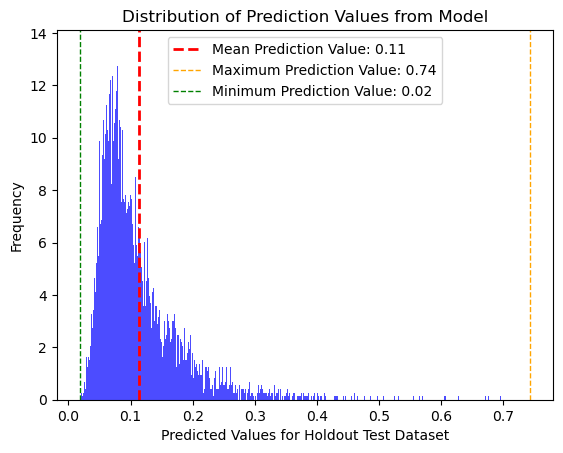

The mean predictive value for the test dataset is: 0.11347168519439964


In [17]:
plt.hist(test_dataset.predictions, bins=1000, density=True, alpha=0.7, color='blue')
plt.xlabel('Predicted Values for Holdout Test Dataset')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Values from Model')

mean_value = np.mean(test_dataset.predictions)
max_value = np.max(test_dataset.predictions)
min_value = np.min(test_dataset.predictions)


# Add mean line to the histogram
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean Prediction Value: {mean_value:.2f}')

plt.axvline(max_value, color='orange', linestyle='dashed', linewidth=1, label=f'Maximum Prediction Value: {max_value:.2f}')

plt.axvline(min_value, color='green', linestyle='dashed', linewidth=1, label=f'Minimum Prediction Value: {min_value:.2f}')


# Display legend
plt.legend()

# Show the histogram
plt.show()

print('The mean predictive value for the test dataset is: {}'.format(mean_value))

### 2.6. Identify Optimal Likelihood Cutoff for our Predictions

As we can see here, our algorithm is hesitant to place much predictive weight behind any particular patient record, and so the majority of our predictions are centered near 0.1 and skew right. As the dataset is weighted heavily towards those who were not readmitted (i.e about 1 in 10 patients being readmitted), this makes sense.

In fact, despiute this rightskew, it almost appears as though there is a small, second hump just above the average value. If we can identify a cutoff that will allow us to predict these records as readmitted, it is likely that our model will perform well regarding an optimal AUC value.

We will therefore institute a prediction/rounding cutoff value lower than 0.5 to determine which records are predicted as being readmitted. As the mean prediction is around 0.11, using this value instead of 0.5 would likely predict around half of records as being classified as readmissions.

We will therefore use a average of these predictions is likely a good place to start. Let us try this value, as well with a few other values to see which cutoff value gives us the best statistical outcome.

As mentioned earlier, optimizing the Area Under the Curve (AUC) metric will be our highest priority, as this metric takes into account both false positives and false negatives.

#### Here we create new lists that will cut probabilities (ranging from 50% to 5%), while focusing on cutoff values close to the mean prediction of 11.3%. 

In [18]:
pred_50 = [1 if i>=0.5 else 0 for i in test_dataset["predictions"]]
pred_20 = [1 if i>=0.2 else 0 for i in test_dataset["predictions"]]
pred_12 = [1 if i>=0.12 else 0 for i in test_dataset["predictions"]]
pred_115 = [1 if i>=0.115 else 0 for i in test_dataset["predictions"]]
pred_113 = [1 if i>=0.11395876273220806 else 0 for i in test_dataset["predictions"]]
pred_11 = [1 if i>=0.11 else 0 for i in test_dataset["predictions"]]
pred_105 = [1 if i>=0.105 else 0 for i in test_dataset["predictions"]]
pred_05 = [1 if i>=0.05 else 0 for i in test_dataset["predictions"]]

#### Each list is now a series of 1/0 values

In [19]:
pred_105[0:20]

[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]

#### Here we list our different prediction lists together

In [20]:
list_of_prediction_lists = [pred_50, pred_20, pred_12, pred_115, pred_113, pred_11, pred_105, pred_05]

#### Here we provde an accompanying name for each list, based off of the respective likelihood cutoff value applied to the list 

In [21]:
names_of_levels = ['50%', '20%', '12%', '11.5%', '11.396% (mean)', '11%', '10.5%', '5%']

#### Here we define the function to conduct our statistical analysis

In [22]:
def XGB_Statistical_Evaluation(probability_rounding_threshold_values, names_of_levels):
    
    '''The CSV_Reader() function takes different readmission predictions, based off of different likelihood roundoff 
    values, and computes different 
    
    Arguments 
    --------- 
    probability_rounding_threshold_values: A list of probabilities for each likelihood cutoff value
    subfolder: A list of names for each item of the probability_rounding_threshold_values list, representing 
        the implimented likelihood cutoff value
    
    Return
    ---------
    For each prediction list, the following is computed:
    -The likelihood cutoff value being used
    -The number of predicted positived
    -The accuracy of the predictions
    -The precision of the predictions
    -The recall of the predictions
    -The F1 score of the predictions
    -The ROC AUC score of the predictions
    '''
    
    for i, j in zip(probability_rounding_threshold_values, names_of_levels):
        y_test = test_dataset['readmitted']
        scores = precision_recall_fscore_support(y_test, i, average='macro', labels=np.unique(i))
        acc = accuracy_score(y_test, i)
        roc = roc_auc_score(y_test, i)
        positives = sum(i)
        
        print()
        print('The cutoff percentage being used for predictions is: {}'.format(j))
        print('Number of predicted readmissions: {}'.format(positives))
        print('Accuracy is: {}'.format(acc))
        print('Precision is: {}'.format(scores[0]))
        print('Recall is: {}'.format(scores[1]))
        print('F1 score is: {}'.format(scores[2]))     
        print('ROC AUC score (i.e. the metric of primary interest) is: {}'.format(roc))

#### Here we assess the statistical output for the predictions from each likelihood cutoff level

In [23]:
XGB_Statistical_Evaluation(list_of_prediction_lists, names_of_levels)


The cutoff percentage being used for predictions is: 50%
Number of predicted readmissions: 24
Accuracy is: 0.8804218066056506
Precision is: 0.7530165536497806
Recall is: 0.5056997897328529
F1 score is: 0.480329203437512
ROC AUC score (i.e. the metric of primary interest) is: 0.505699789732853

The cutoff percentage being used for predictions is: 20%
Number of predicted readmissions: 941
Accuracy is: 0.8363509749303621
Precision is: 0.5814360518302373
Recall is: 0.5653516733011643
F1 score is: 0.57145487678661
ROC AUC score (i.e. the metric of primary interest) is: 0.5653516733011643

The cutoff percentage being used for predictions is: 12%
Number of predicted readmissions: 3300
Accuracy is: 0.6784719458814167
Precision is: 0.5544569510268562
Recall is: 0.6135753352443083
F1 score is: 0.5379098638128267
ROC AUC score (i.e. the metric of primary interest) is: 0.6135753352443083

The cutoff percentage being used for predictions is: 11.5%
Number of predicted readmissions: 3550
Accuracy is

#### By looking at the above, it would appear that the highest AUC value is somewhere between 11.396% and 10.5%, likely around 11%. Let us explore this more granularly...

In [24]:
pred_11 = [1 if i>=0.11 else 0 for i in test_dataset["predictions"]]
pred_110025 = [1 if i>=0.110025 else 0 for i in test_dataset["predictions"]]
pred_11005 = [1 if i>=0.11005 else 0 for i in test_dataset["predictions"]]
pred_110075 = [1 if i>=0.110075 else 0 for i in test_dataset["predictions"]]
pred_1101 = [1 if i>=0.1101 else 0 for i in test_dataset["predictions"]]
pred_110125 = [1 if i>=0.110125 else 0 for i in test_dataset["predictions"]]
pred_11015 = [1 if i>=0.11015 else 0 for i in test_dataset["predictions"]]
pred_110175 = [1 if i>=0.110175 else 0 for i in test_dataset["predictions"]]
pred_1102 = [1 if i>=0.1102 else 0 for i in test_dataset["predictions"]]

#### Here we provde an accompanying name for each list, based off of the respective likelihood cutoff value applied to the list 

In [25]:
more_precise_names_of_levels = ['11%', '11.0025%','11.005%', '11.0075%', '11.01%', '11.0125%', '11.015%', '11.0175%', '11.01%']

#### Here we list our different prediction lists together

In [26]:
more_precise_rounding_threshold_predictions = [pred_11, pred_110025, pred_11005, pred_110075, pred_1101, pred_110125, pred_11015, pred_110175, pred_1102]

#### Here we assess the statistical output for the predictions from each likelihood cutoff level

In [27]:
XGB_Statistical_Evaluation(more_precise_rounding_threshold_predictions, more_precise_names_of_levels)


The cutoff percentage being used for predictions is: 11%
Number of predicted readmissions: 3838
Accuracy is: 0.6372861122164744
Precision is: 0.550317887310219
Recall is: 0.612326686854709
F1 score is: 0.5176585270735689
ROC AUC score (i.e. the metric of primary interest) is: 0.612326686854709

The cutoff percentage being used for predictions is: 11.0025%
Number of predicted readmissions: 3837
Accuracy is: 0.6373855949064863
Precision is: 0.5503482310424958
Recall is: 0.6123832223590057
F1 score is: 0.5177272664750231
ROC AUC score (i.e. the metric of primary interest) is: 0.6123832223590057

The cutoff percentage being used for predictions is: 11.005%
Number of predicted readmissions: 3835
Accuracy is: 0.6371866295264624
Precision is: 0.5499873438666196
Recall is: 0.6115554077894693
F1 score is: 0.5173353789243065
ROC AUC score (i.e. the metric of primary interest) is: 0.6115554077894692

The cutoff percentage being used for predictions is: 11.0075%
Number of predicted readmissions: 

It can be seen that the highest AUC value occurs at a probability threshold of 11.0175%.

From the above results, we can see that a cutoff value of 11.0175% (i.e. those predicted as being 11.0175% risk of readmission) gives us the greatest Area-Under-The-Curve value of 0.6118.

This can be roughly interpreted as: "Given a random readmitted/positive record, and random not-readmitted/negative record, the algorithm will correctly identify the positive record as being more likely to be readmitted than the negative record, 61% of the time.

This value of 0.61 is fairly close to the AUC value of 0.66 that we recieved from our best hyperparameter tuning session off of the validation data subset. This indicates that while there is likely some degree of overfitting present, generally, generally our model does a good job at providing generalizable, unbiased predictions across the entirity of the patient population.

Although the accuracy and precission have decreased due to our lower prediction cutoff point, we are able to predict these costly readmissions demonstratably better with the algorithm than without.

#### Defining our optimal prediction values

In [28]:
optimal_cutoff = pred_110175

### 2.7. Evaluate Model

#### This cell creates the function that will be used to produce a confusion matrix for the predictions derived from the Test dataset.

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def Plot_Confusion_Matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    
    '''The Plot_Confusion_Matrix() function produces a confusion matrix with which to view our final results.
    
    Arguments 
    --------- 
    y_true: the actual readmission values for the test dataset
    y_pred: the predicted readmission values for the test dataset
    classes: The names for the outcome possibilities (i.e. readmitted/not readmitted) 
    title: chart title
    cmap: sets the color gradient
    
    Return
    ---------
    Returns the specified confusion matrix '''
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

#### The below cell produces the confusion matrix detainkling our predictions

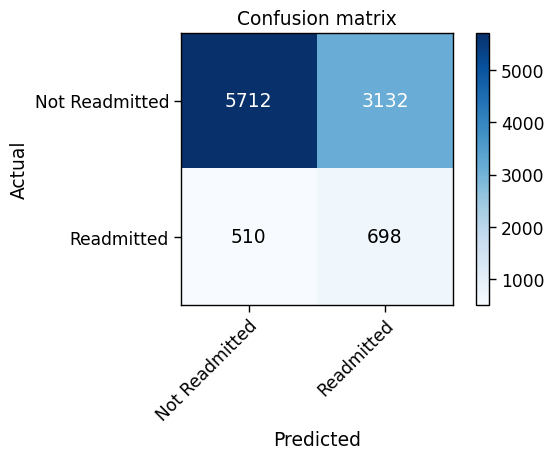

In [31]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = test_dataset['readmitted']
y_pred = optimal_cutoff

class_names = np.array(['Not Readmitted', 'Readmitted'])

# Plot non-normalized confusion matrix
Plot_Confusion_Matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [42]:
XGB_Statistical_Evaluation([optimal_cutoff],["11.0175%"])


The cutoff percentage being used for predictions is: 11.0175%
Number of predicted readmissions: 3830
Accuracy is: 0.637684042976522
Precision is: 0.5501391088473226
Recall is: 0.6118380853109527
F1 score is: 0.5176788624692086
ROC AUC score (i.e. the metric of primary interest) is: 0.6118380853109527


As can be seen in the above confusion matrix, although we are <u>identifying a little more than one third (38%) of patients as being at risk</u> for a readmission, we were <u>correctly identifying close to two thirds (58%) of correct cases</u> among these predictions.

### 2.8 Feature Importance

#### It is also of interest for us to determine what degree of impact different variables had on the outcome. By training a Random Forest model on the whole dataset, we can identify this relationship.

Here we define our Random Forest Model

In [32]:
full_cleaned_dataset = 'aggregate_cleaned_data.csv'

In [33]:
full_diabetes = CSV_Reader(bucket, processed_data_subfolder, full_cleaned_dataset)

In [34]:
full_diabetes_X = full_diabetes.drop(columns='readmitted').values
full_diabetes_y = full_diabetes['readmitted'].values

In [35]:
rfc = rfc()
rfc.set_params(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=60)

#Run ths fit with the initial DF with all conditions:
rfc.fit(full_diabetes_X, full_diabetes_y)

RandomForestClassifier(max_depth=60, min_samples_split=5, n_estimators=200)

In [36]:
#Finally, we list out the importance of each feature:
FIAllDummyAllFeatures = pd.DataFrame({'Feature':pd.Series(full_diabetes.drop(columns='readmitted').columns), 'Importance':rfc.feature_importances_})

FIAllDummyAllFeatures = FIAllDummyAllFeatures.sort_values('Importance', ascending=False)
FIAllDummyAllFeatures

,Feature,Importance
1,num_lab_procedures,0.098811
3,num_medications,0.083784
0,time_in_hospital,0.058069
6,number_inpatient,0.057322
2,num_procedures,0.040606
7,number_diagnoses,0.037695
4,number_outpatient,0.022118
5,number_emergency,0.019894
27,gender_Male,0.017883
14,race_AfricanAmerican,0.014913


It can be seen above that while no single feature is a standaway contributor, those with the highest Importance scores relate to the extent that the individual had interacted with the medical system during their stay, and within the past year.

### 2.9. Assess Financial/Operational Impact of Model

#### To complete our assessment, let us determine the impact our algorithm would have had if implemented on our entire dataset in terms of:<br>
   1. Readmissions Prevented<br>
   2. Dollars Saved

#### Let us identify the relevant numbers from our confusion matrix necessary to populate our financial assessment (i.e. our: 
   True Positives<br>
   False Positives<br>
   False Negatives<br><br>
These correspond to the bottom right, top right, and bottom left cells of the prior confusion matrix.

In [37]:
cm2 = confusion_matrix(full_diabetes['readmitted'], optimal_cutoff)

True_Positives_those_correctly_flagged = cm2[1][1]
False_Positives_those_incorrectly_flagged = cm2[0][1]
False_Negatives_those_missed = cm2[1][0]

print('The number of True Positives (those correctly flagged) is: {}'.format(True_Positives_those_correctly_flagged))
print('The number of False Positives (those incorrectly flagged) is: {}'.format(False_Positives_those_incorrectly_flagged))
print('The number of False Negatives (those missed) is: {}'.format(False_Negatives_those_missed))

The number of True Positives (those correctly flagged) is: 698
The number of False Positives (those incorrectly flagged) is: 3132
The number of False Negatives (those missed) is: 510


#### Next, let us define a few variables: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The <u>cost of each readmission</u> is estimated at <u>$15,000</u> <br><br>
   A diabetes-management-program is a patient-follow-up regimen, with the goal of preventing a readmission, and ultimately enabling the patient to manage their diabetes.<br><br>
   
The following variables pertaining to readmissions are defined/estimated below:<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The <u>cost of implimenting the diabetes-management-program</u> for 1 month is estimated at <u>$500</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The <u>likelihood</u> of the diabetes-management-program <u>preventing a readmission is</u> estimated at <u>50%</u><br><br>

Obviously, each of these variables are likely to vary across health systems, and these are just estimation values. However an update of these variables would enable a simple update of this assessment.

In [38]:
cost_of_readmission = 15000
cost_of_management_program = 500
sucess_rate_of_intervention = 0.5

#### Below we calculate the total cost of the program, and the total number of readmissions that the program would prevent.

In [39]:
total_cost_of_implimenting_program = cost_of_management_program*(True_Positives_those_correctly_flagged+False_Positives_those_incorrectly_flagged)

readmissions_prevented = sucess_rate_of_intervention*True_Positives_those_correctly_flagged

print('The total cost of implementing the program across {} patients would be: ${}'.format((True_Positives_those_correctly_flagged + False_Positives_those_incorrectly_flagged), total_cost_of_implimenting_program))
print('The total number of prevented readmissions would be : {}'.format(readmissions_prevented))

The total cost of implementing the program across 3830 patients would be: $1915000
The total number of prevented readmissions would be : 349.0


#### Now, we calculate the difference between the expense of implimenting the program (about $2 Million) with the savings from prevented readmissions.

In [40]:
savings_from_readmissions_prevention = (readmissions_prevented) * (cost_of_readmission)

net_savings_to_hosptial_system = (savings_from_readmissions_prevention) - (total_cost_of_implimenting_program)

per_patient_savings = net_savings_to_hosptial_system/len(optimal_cutoff)

print('The savings stemming from prevented readmissions would be: ${}'.format(savings_from_readmissions_prevention))
print('The net savings from implementing the program would be : ${}'.format(net_savings_to_hosptial_system))
print('The per-patient savings would be: ${}'.format(per_patient_savings))

The savings stemming from prevented readmissions would be: $5235000.0
The net savings from implementing the program would be : $3320000.0
The per-patient savings would be: $330.2825308396339


#### As we can see, using machine learning to identify diabetic patients at risk for a readmission can provide dramatic per-patient financial savings.

Even with the high number of false positives, (i.e. 3132, indicative of a diabetes-management-program being implimented on a patient who would not have otherwise been readmitted -- over 4 false positives for each true positive) The savings derived from the patients that would have be readmitted (349 -- or up to 698 with a diabetes-management-program that is more than 50% effective) makes up for this at a rate of saving nearly 3 dollars saved on prevented readmissions for every 1 dollar spent on the diabetes-management-program. 

Furthermore, it is likely that the diabetes management program may have significant residual health benefits on both the true and false positive populations applied to. As both of these populations are presumably at risk for complications stemming from their diabetes, these programs may promote a healthly lifestyle and prevent costly complications down the road.

#### In summation, 5.3 Million dollars would be saved from readmissions, with 1.9 Million would be spent on the program, leading to an aggregate 340 dollar savings per-patient.